# FDS Assignment 1 -UN General Debate Speeches

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.tokenize import sent_tokenize
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [25]:
# change arrange to (1, 79) to get all years and add if clause to change 1 -> 01 when single digit to match "Session 01 - 1946"
sessions = np.arange(55, 79)
keywords = ['gender', 'women', 'girl', 'queer', 'female', 'feminis*', 'non-binary', 'non binary', 'sexes', 'LGBTQ*', 'patriarchy', 'transgender', 'two-spirit', 'gender equality', 'violence against women', 'trafficking', 'forced marriage']
data=[]

for session in sessions:
    directory = "./Datasets/TXT/Session "+str(session)+" - "+str(1945+session)
    #directory = f"./TXT/Session {session} - {1945+session}"
    for filename in os.listdir(directory):
         #f = open(os.path.join(directory, filename))
        with open(os.path.join(directory, filename),encoding='utf-8') as f:
            if filename[0]==".": #ignore hidden files
                continue
            # split filename into ISO3 country code, session number and year
            splt = filename.split("_")
            # read speech text and make lower case for keyword counting
            speech_text = f.read().lower()
            speech_text = speech_text.replace('\n', ' ')
            keyword_counts = {keyword: speech_text.count(keyword) for keyword in keywords}

            data.append([session, 1945+session, splt[0], speech_text] + list(keyword_counts.values()))

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech']+keywords)
df_speech.rename(columns={'ISO-alpha3 Code': 'Country Code'}, inplace=True)
df_speech['Year'] = df_speech['Year'].astype(int)

df_speech.head()

,Session,Year,Country Code,Speech,gender,women,girl,queer,female,feminis*,...,non binary,sexes,LGBTQ*,patriarchy,transgender,two-spirit,gender equality,violence against women,trafficking,forced marriage
0,55,2000,AFG,"on my way to the assembly hall, i was informed...",0,7,2,0,3,0,...,0,0,0,0,0,0,0,0,4,0
1,55,2000,AGO,"allow me to begin by congratulating you, sir, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55,2000,ALB,"allow me to congratulate you, sir, on your ele...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55,2000,AND,"andorra will become, through the western europ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,55,2000,ARE,"i have the honour to convey to you, on behalf ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Gender Inequality Index

In [26]:
df_gender_inequality = pd.read_csv('Datasets/Gender-Inequality-Index.csv')
df_gender_inequality.set_index(['Country', 'ISO3'], inplace=True)
columns_to_remove = ['Continent', 'Hemisphere', 'Human Development Groups' ,'UNDP Developing Regions', 'HDI Rank (2021)', 'GII Rank (2021)']
df_gender_inequality.drop(columns=columns_to_remove, inplace=True)

df_gii = pd.melt(df_gender_inequality.reset_index(), 
                  id_vars=['Country', 'ISO3'], 
                  var_name='Year', 
                  value_name='Gender Inequality Index')

# Extracting just the year from 'Year' column
df_gii['Year'] = df_gii['Year'].str.extract(r'(\d+)')
df_gii.rename(columns={'ISO3': 'Country Code'}, inplace=True)
df_gii['Year'] = df_gii['Year'].astype(int)
df_gii.set_index(['Country Code','Year'], inplace=True)
df_gii.head()

,,Country,Gender Inequality Index
Country Code,Year,,
AFG,1990,Afghanistan,NaN
AGO,1990,Angola,0.725
ALB,1990,Albania,NaN
AND,1990,Andorra,NaN
ARE,1990,United Arab Emirates,0.659


## Unemployment for Males and Females

In [27]:
data = pd.read_csv('Datasets/Unemployment.csv', index_col=[3,4])
unemploymentDataFrame = data[['Indicator Name','Value','Country Name']]
unemploymentDataFrame = unemploymentDataFrame[unemploymentDataFrame.index.get_level_values('Year') >= 2000]  
unemploymentDataFrame = unemploymentDataFrame[(unemploymentDataFrame['Indicator Name'] == 'Unemployment, female (% of female labor force) (modeled ILO estimate)') | 
                                              (unemploymentDataFrame['Indicator Name'] == 'Unemployment, male (% of male labor force) (modeled ILO estimate)')]
#unemploymentDataFrame

In [28]:
females = unemploymentDataFrame[unemploymentDataFrame['Indicator Name'] == 'Unemployment, female (% of female labor force) (modeled ILO estimate)']
females = females[['Country Name','Value']].rename(columns={'Value': 'Unemployment females'})

# Filter unemployment data for males
males = unemploymentDataFrame[unemploymentDataFrame['Indicator Name'] == 'Unemployment, male (% of male labor force) (modeled ILO estimate)']
males = males[['Value']].rename(columns={'Value': 'Unemployment males'})



# Merge both datasets based on the existing multi-index (Country Name, Year)
unemploymentTotal = pd.merge(females, males, left_index=True, right_index=True, how='outer')

## Percentage of female labor force

In [29]:
df_labor_force = pd.read_csv('Datasets/Labor-force-female.csv')
df_labor_force = df_labor_force.set_index(['Country Code','Year']).drop(columns=['Indicator Name','Indicator Code','Disaggregation'], axis=1)
df_labor_force.rename(columns={'Value': 'Labor force (%)'},inplace=True)

df_labor_force.reset_index(inplace=True)  
df_labor_force['Country Name'] = df_labor_force['Country Name'].replace('Turkiye', 'Turkey')

df_labor_force.set_index(['Country Code', 'Year'], inplace=True)
df_labor_force

Country Name  Labor force (%)
Country Code Year                                              
AFE          2023  Africa Eastern and Southern           47.347
             2022  Africa Eastern and Southern           47.279
             2021  Africa Eastern and Southern           47.386
             2020  Africa Eastern and Southern           47.235
             2019  Africa Eastern and Southern           47.242
...                                        ...              ...
ZWE          1995                     Zimbabwe           48.571
             1994                     Zimbabwe           48.213
             1993                     Zimbabwe           47.758
             1992                     Zimbabwe           47.331
             1991                     Zimbabwe           47.058

[7752 rows x 2 columns]

## Proportion of seats held by women in the national parliaments

In [30]:
df_parliament_seats = pd.read_csv('Datasets/Proportion-seats–held–by-women-in-national-parliaments.csv')
drop_list = ['Indicator Code', 'Indicator Name', 'Disaggregation', 'Country Name']
df_parliament_seats.set_index(['Country Code','Year'], inplace=True)
df_parliament_seats.drop(columns= drop_list, inplace=True)
df_parliament_seats.rename(columns={'Value': 'Proportion Of Seats Held By Women In National Parliaments (%)'}, inplace=True)
df_parliament_seats.head()

Proportion Of Seats Held By Women In National Parliaments (%)
Country Code Year                                                               
AFE          2023                                             30.518            
             2022                                             30.524            
             2021                                             30.475            
             2020                                             30.128            
             2019                                             29.275

## Merged dataset for Explorative Analysis

In [31]:
# merging on speech and gender ineq. index
data_merge = pd.merge(df_speech, df_gii, left_on=['Country Code', 'Year'], right_on=['Country Code','Year'], how='inner')

# merging the merged data and df_labor_force
data_merge = pd.merge(data_merge, df_labor_force, left_on=['Country Code', 'Year'],right_on=['Country Code','Year'],how='inner')

# merging with parlement seats
data_merge = pd.merge(data_merge, df_parliament_seats, left_on=['Country Code', 'Year'],right_on=['Country Code','Year'],how='inner')

# merging with unemployment
df_analysis = pd.merge(data_merge, unemploymentTotal, left_on=['Country Code', 'Year', 'Country'],right_on=['Country Code','Year', 'Country Name'],how='inner')

df_analysis.drop(columns=['Country Name_x','Country Name_y'],inplace=True)
df_analysis = df_analysis.set_index(['Country Code','Year'])
df_analysis.head()

,,Session,Speech,gender,women,girl,queer,female,feminis*,non-binary,non binary,...,gender equality,violence against women,trafficking,forced marriage,Country,Gender Inequality Index,Labor force (%),Proportion Of Seats Held By Women In National Parliaments (%),Unemployment females,Unemployment males
Country Code,Year,,,,,,,,,,,,,,,,,,,,,
AGO,2000,55,"allow me to begin by congratulating you, sir, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,Angola,0.671,50.511,15.455,18.466,14.497
ALB,2000,55,"allow me to congratulate you, sir, on your ele...",0,0,0,0,0,0,0,0,...,0,0,0,0,Albania,0.319,41.907,5.161,18.538,19.374
ARE,2000,55,"i have the honour to convey to you, on behalf ...",0,0,0,0,0,0,0,0,...,0,0,0,0,United Arab Emirates,0.605,12.206,0.000,2.716,2.185
ARG,2000,55,"in this, my first statement, allow me to congr...",1,0,0,0,0,0,0,0,...,0,0,2,0,Argentina,0.413,41.558,26.459,16.360,14.033
ARM,2000,55,allow me to join my colleagues in congratulati...,0,0,0,0,0,0,0,0,...,0,0,0,0,Armenia,0.453,48.713,3.053,14.404,7.956


# Analysis
## Explanatory Analysis
Is there a statistically significant correlation between the frequency of mentions of women's rights in public speeches and the progress made in gender equality indicators (unemployment rate (men and women), labor force participation rate, and parliamentary seats held by women) in selected countries or continents? (keywords of gender inequality)
- Filter on countries that have data available from 2000-2023
- 3 highest 3 lowest GII and HDI
### Parameters
- Frequency of keywords
- Men & female unemployment rate
- Labor force participation
- Parliamentary seats held by women
- Gender pay gap (OPTIONAL)
- Happiness index (OPTIONAL)

### Frequency of mentions of women's rights in the UN General Debate speeches 
#### Keyword counts over the years (all countries) 

In [32]:
# Count the unique countries per year
country_count = df_analysis.groupby('Year')['Country'].nunique()

# Sum keyword occurrences per year
df_analysis_copy = df_analysis
df_analysis_copy = df_analysis_copy.reset_index('Year')
keywords_perYear = df_analysis_copy[['Year'] + keywords].groupby('Year').sum()
keywords_perYear['total'] = keywords_perYear.sum(axis=1)

keywords_allCountries = df_analysis[['Country'] + keywords].groupby('Country').sum()
keywords_allCountries['total'] = keywords_allCountries.sum(axis=1)

# Calculate total keywords for each country and find max
df_analysis['Total Keywords'] = df_analysis[keywords].sum(axis=1)
max_keywords_allCountries = df_analysis.loc[df_analysis.groupby('Year')['Total Keywords'].idxmax()]

keywords_analysis_total = pd.DataFrame({
    '# Participating countries': country_count,
    'Country with Most Keyword Mentions': max_keywords_allCountries['Country'].values,
    'Max Keyword Counts': max_keywords_allCountries['Total Keywords'].values
})

keywords_analysis_total = keywords_analysis_total.merge(keywords_perYear, left_on='Year', right_on='Year')

# Remvoing keywords from columns as they are no longer needed
df_analysis.drop(columns=keywords, inplace=True)

In [33]:
df_analysis.head()

,,Session,Speech,Country,Gender Inequality Index,Labor force (%),Proportion Of Seats Held By Women In National Parliaments (%),Unemployment females,Unemployment males,Total Keywords
Country Code,Year,,,,,,,,,
AGO,2000,55,"allow me to begin by congratulating you, sir, ...",Angola,0.671,50.511,15.455,18.466,14.497,0
ALB,2000,55,"allow me to congratulate you, sir, on your ele...",Albania,0.319,41.907,5.161,18.538,19.374,0
ARE,2000,55,"i have the honour to convey to you, on behalf ...",United Arab Emirates,0.605,12.206,0.000,2.716,2.185,0
ARG,2000,55,"in this, my first statement, allow me to congr...",Argentina,0.413,41.558,26.459,16.360,14.033,3
ARM,2000,55,allow me to join my colleagues in congratulati...,Armenia,0.453,48.713,3.053,14.404,7.956,0


#### Keyword counts over the years (all countries) (Might delete from final version as not sure how to use in report)

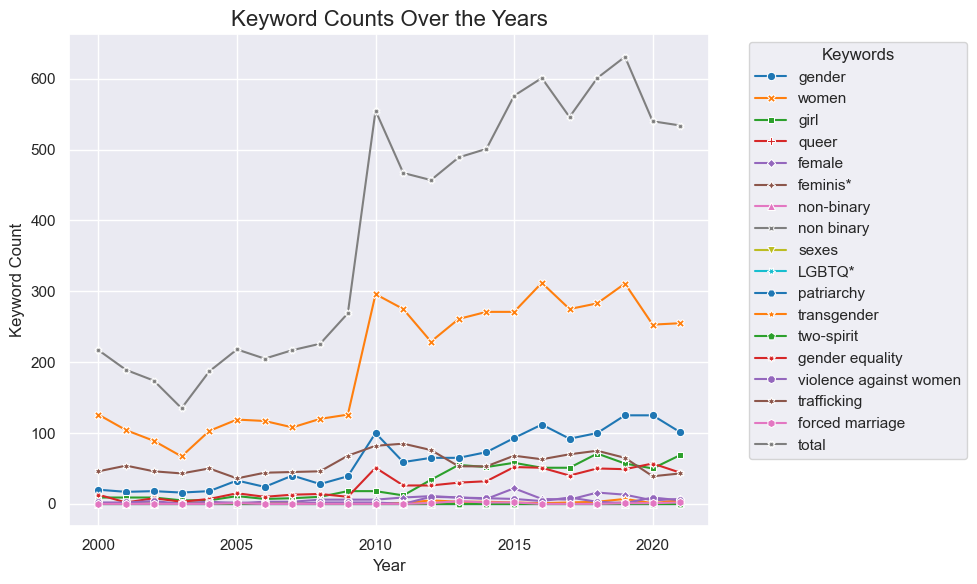

In [34]:
# Set the style and figure size 
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))  

# Plot each line with seaborn
ax = sns.lineplot(data=keywords_perYear, markers=True, dashes=False, palette='tab10')
plt.title('Keyword Counts Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Keyword Count', fontsize=12)

# Move the legend outside the plot
plt.legend(title='Keywords', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

#### Summary of Data for different countries

##### Summary of Data for High HDI countries

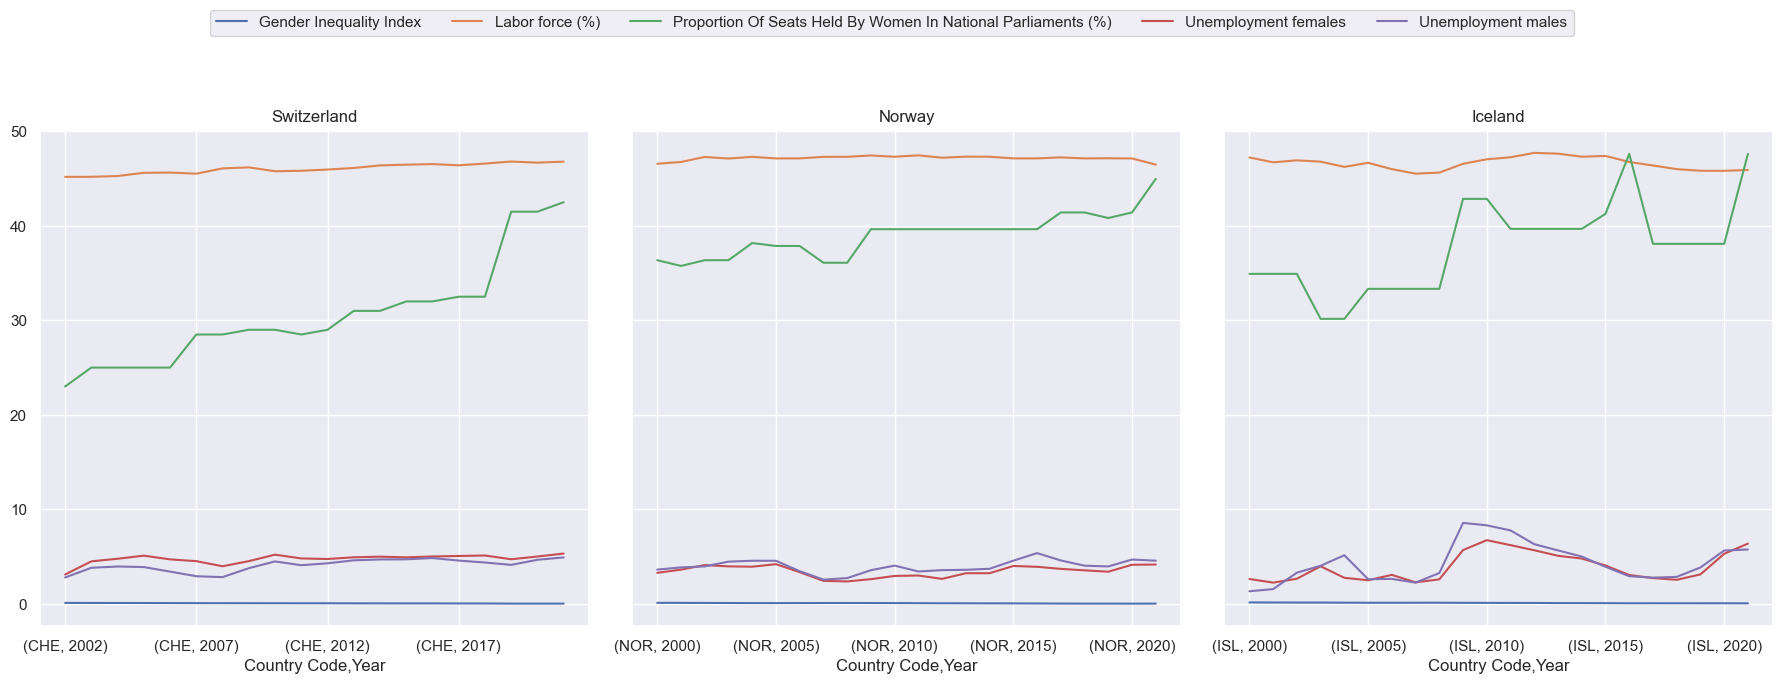

In [35]:
# Set up the figure and axes for three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Create a list of the countries you want to plot
countries = ['Switzerland', 'Norway', 'Iceland']

# Iterate through the countries and plot each one on a separate subplot
for i, country in enumerate(countries):
    # Filter the DataFrame for the specific country
    df_country = df_analysis[df_analysis['Country'] == country].copy()
    df_country.drop(columns=['Session', 'Speech'], inplace=True)
    
    # Plot the data on the corresponding subplot axis
    df_country[['Gender Inequality Index', 'Labor force (%)', 'Proportion Of Seats Held By Women In National Parliaments (%)', 
                'Unemployment females', 'Unemployment males']].plot(ax=axes[i], title=country, legend=False)
    
    # Set the title for each subplot
    axes[i].set_title(country)

# Set a common legend for the figure
fig.legend(['Gender Inequality Index', 'Labor force (%)', 'Proportion Of Seats Held By Women In National Parliaments (%)', 
            'Unemployment females', 'Unemployment males'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

##### Summary of Data for Low HDI Countries

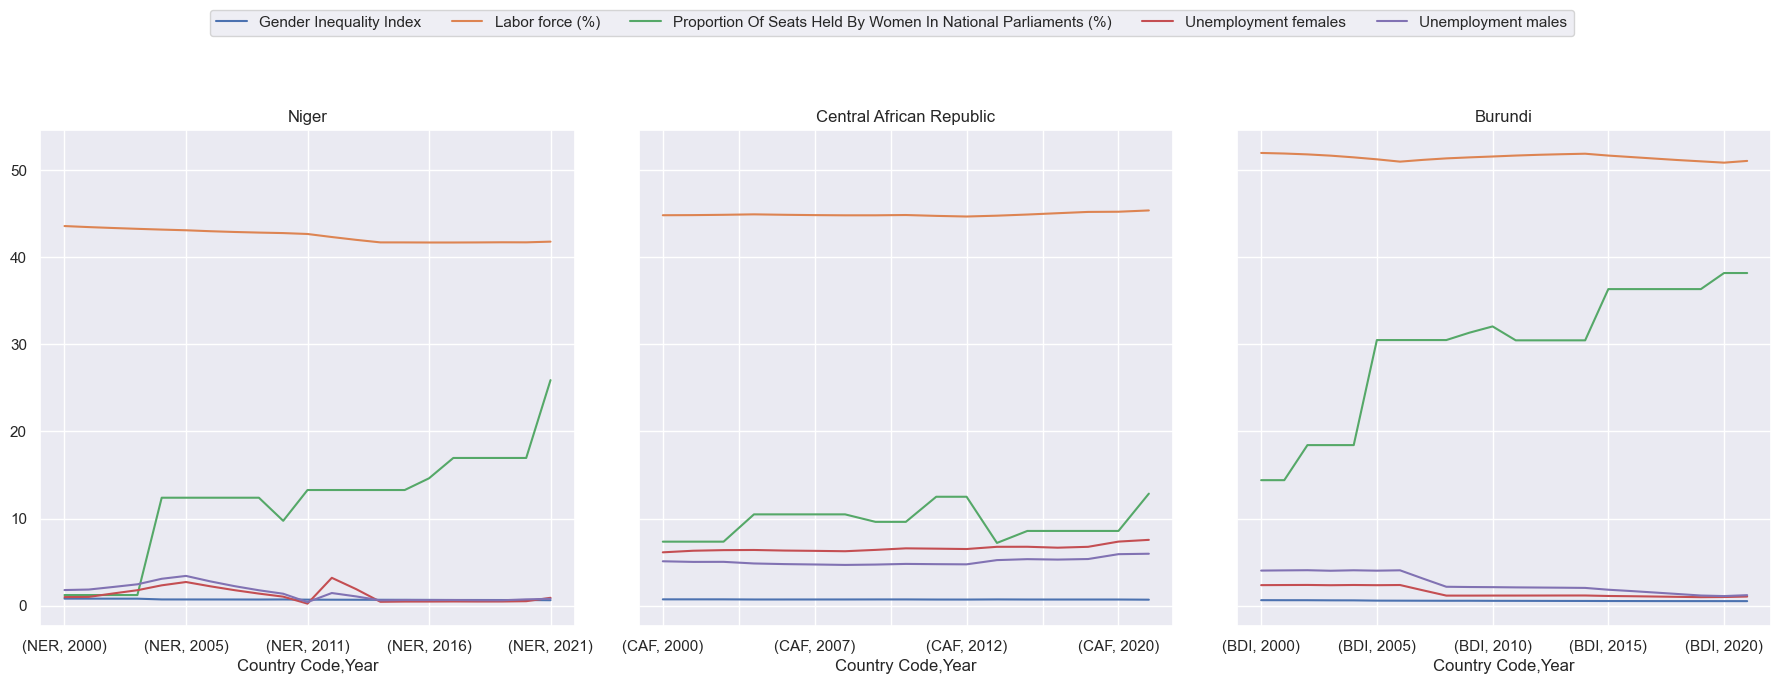

In [36]:
# Set up graphs in single row
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Countries to plot
countries = ['Niger', 'Central African Republic', 'Burundi']

# Iterate through the countries and plot each one on a separate subplot
for i, country in enumerate(countries):
    # Filter the DataFrame for the specific country
    df_country = df_analysis[df_analysis['Country'] == country].copy()
    df_country.drop(columns=['Session', 'Speech'], inplace=True)
    
    # Plot the data on the corresponding subplot axis
    df_country[['Gender Inequality Index', 'Labor force (%)', 'Proportion Of Seats Held By Women In National Parliaments (%)', 
                'Unemployment females', 'Unemployment males']].plot(ax=axes[i], title=country, legend=False)
    
    # Set the title 
    axes[i].set_title(country)

# Set a common legend for the figure
fig.legend(['Gender Inequality Index', 'Labor force (%)', 'Proportion Of Seats Held By Women In National Parliaments (%)', 
            'Unemployment females', 'Unemployment males'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Combining High/Low HDI countries in one dataframe to compare better

In [37]:
# Combining high HDI countries into one dataframe
df_analysis_Switzerland = df_analysis[df_analysis['Country'] == 'Switzerland'].copy()
df_analysis_Switzerland.drop(columns=['Session', 'Speech'], inplace=True)

df_analysis_Norway = df_analysis[df_analysis['Country'] == 'Norway'].copy()
df_analysis_Norway.drop(columns=['Session', 'Speech'], inplace=True)

df_analysis_Iceland = df_analysis[df_analysis['Country'] == 'Iceland'].copy()
df_analysis_Iceland.drop(columns=['Session', 'Speech'], inplace=True)

df_analysis_high_hdi = pd.concat([df_analysis_Switzerland, df_analysis_Norway, df_analysis_Iceland])

# Combining low HDI countries into one dataframe
df_analysis_Niger = df_analysis[df_analysis['Country'] == 'Niger'].copy()
df_analysis_Niger.drop(columns=['Session', 'Speech'], inplace=True)

df_analysis_CAF = df_analysis[df_analysis['Country'] == 'Central African Republic'].copy()
df_analysis_CAF.drop(columns=['Session', 'Speech'], inplace=True)

df_analysis_Burundi = df_analysis[df_analysis['Country'] == 'Burundi'].copy()
df_analysis_Burundi.drop(columns=['Session', 'Speech'], inplace=True)

df_analysis_low_hdi = pd.concat([df_analysis_Niger, df_analysis_CAF, df_analysis_Burundi])

##### Scatter plot for Low HDI countries

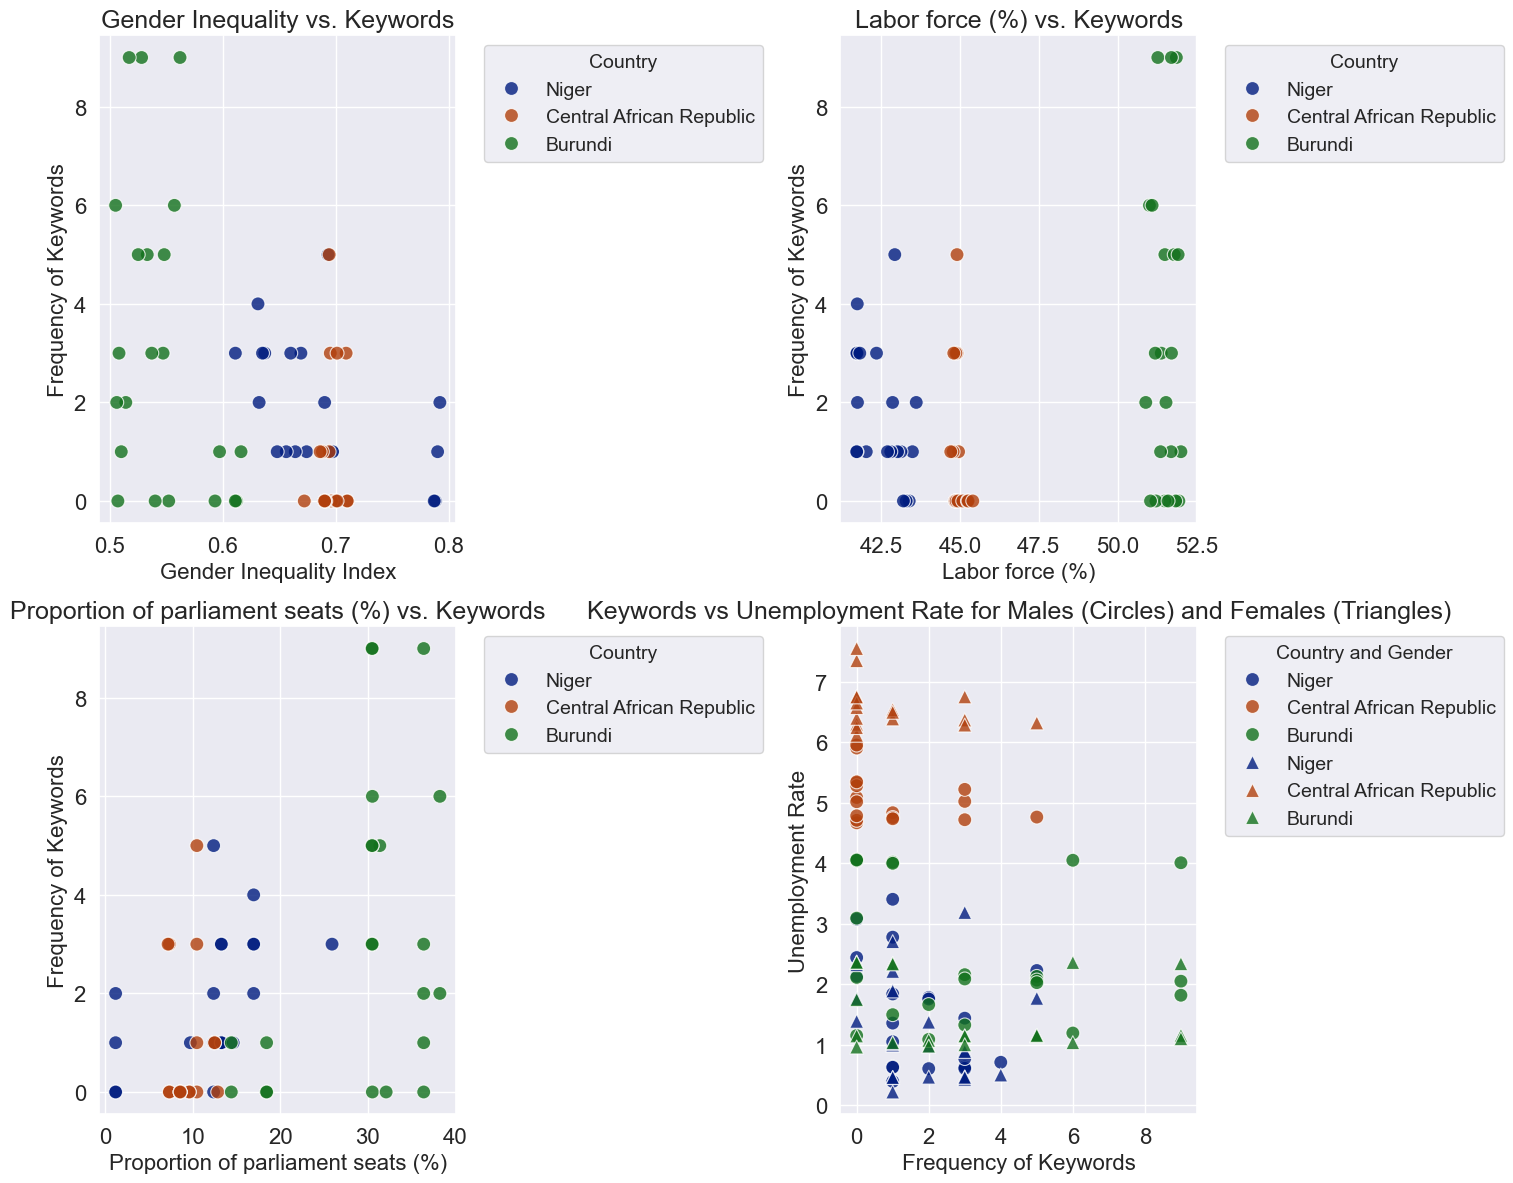

Pearson Correlation between Gender Inequality Index and Total Keywords: -0.45595765980204694, P-value: 0.0002510926676871371
Pearson Correlation between Labor Force (%) and Total Keywords: 0.2918238713517677, P-value: 0.02367278727782206
Pearson Correlation between Proportion of seats held by women in national parliaments (%) and Total Keywords: 0.494523706084662, P-value: 5.91534793662317e-05
Pearson Correlation between Unemployment for females and Total Keywords: -0.3108791479656092, P-value: 0.015621498662817835


In [38]:
# Create a figure with subplots arranged in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  

# Set general font sizes for labels and titles
label_fontsize = 16
title_fontsize = 18
legend_fontsize = 14

# Plot 1: Gender Inequality Index vs. Total Keywords
sns.scatterplot(
    data=df_analysis_low_hdi, 
    x='Gender Inequality Index', 
    y='Total Keywords', 
    hue='Country', 
    palette='dark', 
    s=100, 
    alpha=0.8, 
    ax=axes[0, 0]
)
axes[0, 0].set_xlabel('Gender Inequality Index', fontsize=label_fontsize)
axes[0, 0].set_ylabel('Frequency of Keywords', fontsize=label_fontsize)
axes[0, 0].set_title('Gender Inequality vs. Keywords', fontsize=title_fontsize)
axes[0, 0].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[0, 0].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[0, 0].grid(True)

# Plot 2: Labor force (%) vs. Frequency of Keywords
sns.scatterplot(
    data=df_analysis_low_hdi, 
    x='Labor force (%)', 
    y='Total Keywords', 
    hue='Country', 
    palette='dark', 
    s=100, 
    alpha=0.8, 
    ax=axes[0, 1]
)
axes[0, 1].set_xlabel('Labor force (%)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('Frequency of Keywords', fontsize=label_fontsize)
axes[0, 1].set_title('Labor force (%) vs. Keywords', fontsize=title_fontsize)
axes[0, 1].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[0, 1].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[0, 1].grid(True)

# Plot 3: Proportion of seats held by women in national parliaments (%) vs. Frequency of Keywords
sns.scatterplot(
    data=df_analysis_low_hdi, 
    x='Proportion Of Seats Held By Women In National Parliaments (%)', 
    y='Total Keywords', 
    hue='Country', 
    palette='dark', 
    s=100, 
    alpha=0.8, 
    ax=axes[1, 0]
)
axes[1, 0].set_xlabel('Proportion of parliament seats (%)', fontsize=label_fontsize)
axes[1, 0].set_ylabel('Frequency of Keywords', fontsize=label_fontsize)
axes[1, 0].set_title('Proportion of parliament seats (%) vs. Keywords', fontsize=title_fontsize)
axes[1, 0].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[1, 0].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[1, 0].grid(True)

# Plot 4: Total Keywords vs. Unemployment Rate for Males and Females
sns.scatterplot(
    data=df_analysis_low_hdi, 
    x='Total Keywords', 
    y='Unemployment males', 
    hue='Country', 
    palette='dark', 
    marker='o', 
    s=100, 
    alpha=0.8, 
    ax=axes[1, 1]
)

sns.scatterplot(
    data=df_analysis_low_hdi, 
    x='Total Keywords', 
    y='Unemployment females', 
    hue='Country', 
    palette='dark', 
    marker='^', 
    s=100, 
    alpha=0.8, 
    ax=axes[1, 1]
)

axes[1, 1].set_xlabel('Frequency of Keywords', fontsize=label_fontsize)
axes[1, 1].set_ylabel('Unemployment Rate', fontsize=label_fontsize)
axes[1, 1].set_title('Keywords vs Unemployment Rate for Males (Circles) and Females (Triangles)', fontsize=title_fontsize)
axes[1, 1].legend(title='Country and Gender', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[1, 1].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation 
low_gii_pearson_corr, low_gii_pearson_pval = pearsonr(df_analysis_low_hdi['Gender Inequality Index'], df_analysis_low_hdi['Total Keywords'])
print(f"Pearson Correlation between Gender Inequality Index and Total Keywords: {low_gii_pearson_corr}, P-value: {low_gii_pearson_pval}")
low_labor_pearson_corr, low_labor_pearson_pval = pearsonr(df_analysis_low_hdi['Labor force (%)'], df_analysis_low_hdi['Total Keywords'])
print(f"Pearson Correlation between Labor Force (%) and Total Keywords: {low_labor_pearson_corr}, P-value: {low_labor_pearson_pval}")
low_parliament_pearson_corr, low_parliament_pearson_pval = pearsonr(df_analysis_low_hdi['Proportion Of Seats Held By Women In National Parliaments (%)'], df_analysis_low_hdi['Total Keywords'])
print(f"Pearson Correlation between Proportion of seats held by women in national parliaments (%) and Total Keywords: {low_parliament_pearson_corr}, P-value: {low_parliament_pearson_pval}")
low_unemployment_pearson_corr, low_unemployment_pearson_pval = pearsonr(df_analysis_low_hdi['Unemployment females'], df_analysis_low_hdi['Total Keywords'])
print(f"Pearson Correlation between Unemployment for females and Total Keywords: {low_unemployment_pearson_corr}, P-value: {low_unemployment_pearson_pval}")

##### Scatter plot for High HDI countries

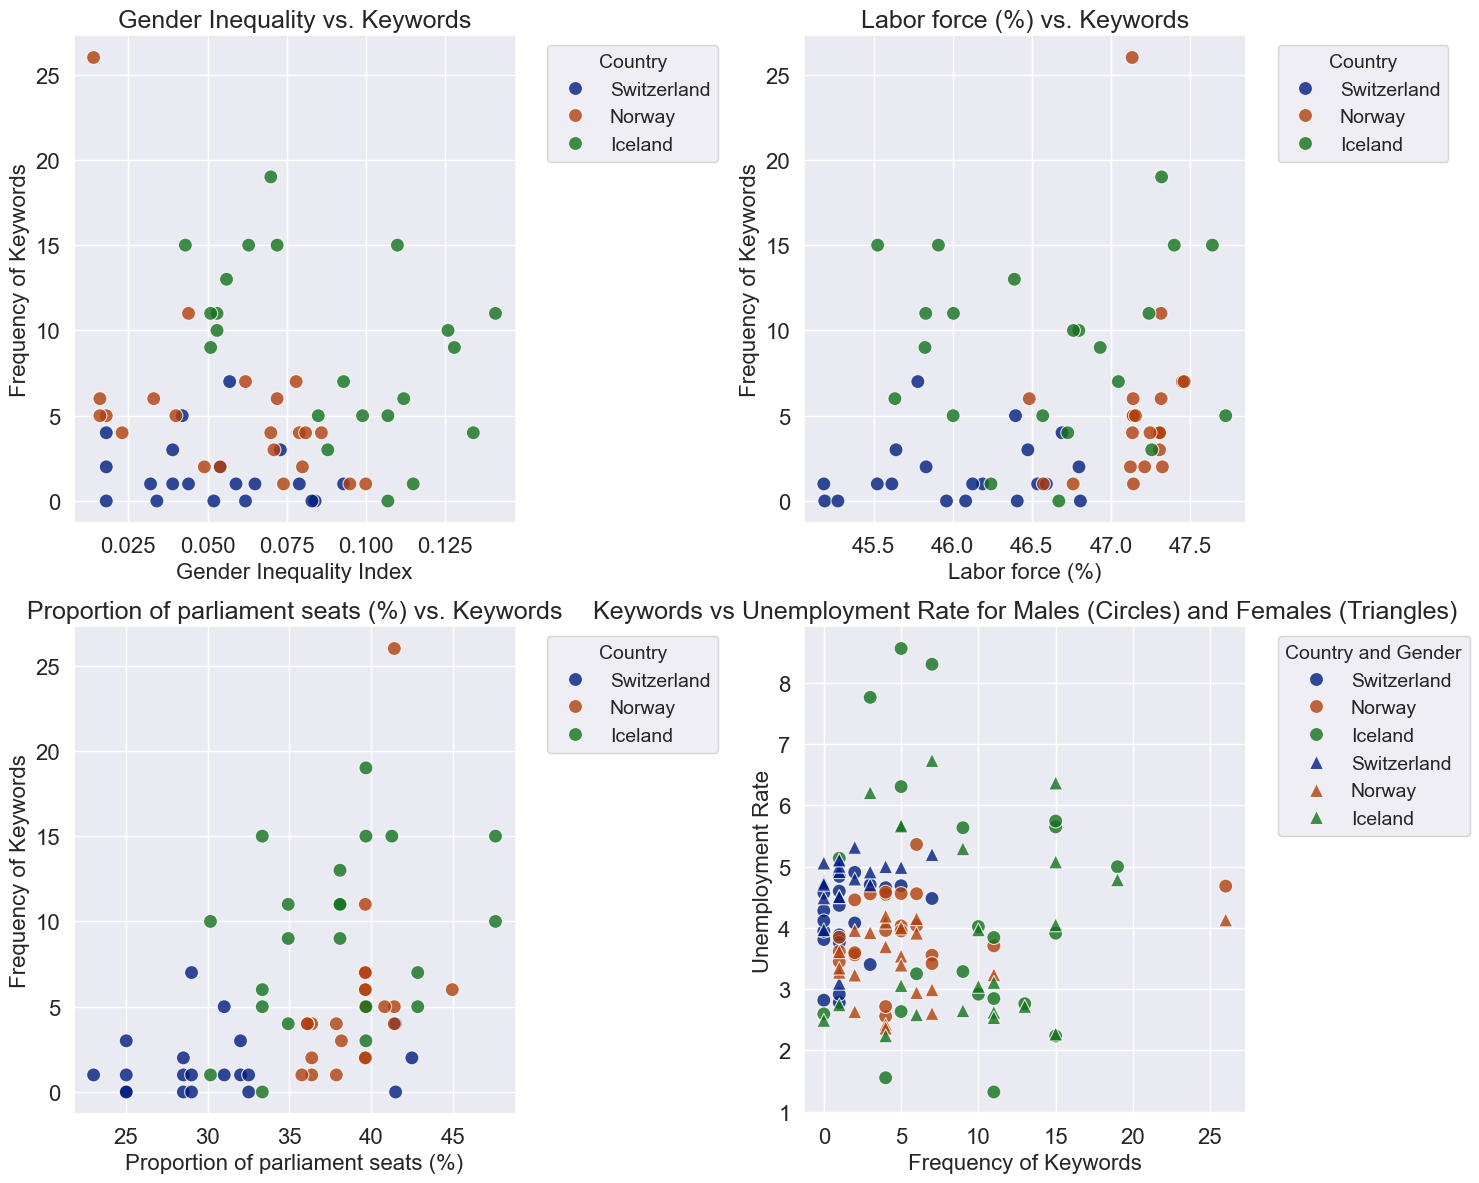

Pearson Correlation between Gender Inequality Index and Total Keywords: -0.02665523801522028, P-value: 0.8343887653723638
Pearson Correlation between Labor Force (%) and Total Keywords: 0.2225588214400443, P-value: 0.0771241555760789
Pearson Correlation between Proportion of seats held by women in national parliaments (%) and Total Keywords: 0.45055745375479295, P-value: 0.0001870252349302968
Pearson Correlation between Unemployment for females and Total Keywords: -0.08035959652132618, P-value: 0.5278912621467006


In [39]:
# Create a figure with subplots arranged in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  

# Set general font sizes for labels and titles
label_fontsize = 16
title_fontsize = 18
legend_fontsize = 14

# Plot 1: Gender Inequality Index vs. Total Keywords
sns.scatterplot(
    data=df_analysis_high_hdi, 
    x='Gender Inequality Index', 
    y='Total Keywords', 
    hue='Country', 
    palette='dark', 
    s=100, 
    alpha=0.8, 
    ax=axes[0, 0]
)
axes[0, 0].set_xlabel('Gender Inequality Index', fontsize=label_fontsize)
axes[0, 0].set_ylabel('Frequency of Keywords', fontsize=label_fontsize)
axes[0, 0].set_title('Gender Inequality vs. Keywords', fontsize=title_fontsize)
axes[0, 0].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[0, 0].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[0, 0].grid(True)

# Plot 2: Labor force (%) vs. Frequency of Keywords
sns.scatterplot(
    data=df_analysis_high_hdi, 
    x='Labor force (%)', 
    y='Total Keywords', 
    hue='Country', 
    palette='dark', 
    s=100, 
    alpha=0.8, 
    ax=axes[0, 1]
)
axes[0, 1].set_xlabel('Labor force (%)', fontsize=label_fontsize)
axes[0, 1].set_ylabel('Frequency of Keywords', fontsize=label_fontsize)
axes[0, 1].set_title('Labor force (%) vs. Keywords', fontsize=title_fontsize)
axes[0, 1].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[0, 1].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[0, 1].grid(True)

# Plot 3: Proportion of seats held by women in national parliaments (%) vs. Frequency of Keywords
sns.scatterplot(
    data=df_analysis_high_hdi, 
    x='Proportion Of Seats Held By Women In National Parliaments (%)', 
    y='Total Keywords', 
    hue='Country', 
    palette='dark', 
    s=100, 
    alpha=0.8, 
    ax=axes[1, 0]
)
axes[1, 0].set_xlabel('Proportion of parliament seats (%)', fontsize=label_fontsize)
axes[1, 0].set_ylabel('Frequency of Keywords', fontsize=label_fontsize)
axes[1, 0].set_title('Proportion of parliament seats (%) vs. Keywords', fontsize=title_fontsize)
axes[1, 0].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[1, 0].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[1, 0].grid(True)

# Plot 4: Total Keywords vs. Unemployment Rate for Males and Females
sns.scatterplot(
    data=df_analysis_high_hdi, 
    x='Total Keywords', 
    y='Unemployment males', 
    hue='Country', 
    palette='dark', 
    marker='o', 
    s=100, 
    alpha=0.8, 
    ax=axes[1, 1]
)

sns.scatterplot(
    data=df_analysis_high_hdi, 
    x='Total Keywords', 
    y='Unemployment females', 
    hue='Country', 
    palette='dark', 
    marker='^', 
    s=100, 
    alpha=0.8, 
    ax=axes[1, 1]
)

axes[1, 1].set_xlabel('Frequency of Keywords', fontsize=label_fontsize)
axes[1, 1].set_ylabel('Unemployment Rate', fontsize=label_fontsize)
axes[1, 1].set_title('Keywords vs Unemployment Rate for Males (Circles) and Females (Triangles)', fontsize=title_fontsize)
axes[1, 1].legend(title='Country and Gender', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
axes[1, 1].tick_params(labelsize=label_fontsize)  # Increase tick label font size
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation 
high_gii_pearson_corr, high_gii_pearson_pval = pearsonr(df_analysis_high_hdi['Gender Inequality Index'], df_analysis_high_hdi['Total Keywords'])
print(f"Pearson Correlation between Gender Inequality Index and Total Keywords: {high_gii_pearson_corr}, P-value: {high_gii_pearson_pval}")
high_labor_pearson_corr, high_labor_pearson_pval = pearsonr(df_analysis_high_hdi['Labor force (%)'], df_analysis_high_hdi['Total Keywords'])
print(f"Pearson Correlation between Labor Force (%) and Total Keywords: {high_labor_pearson_corr}, P-value: {high_labor_pearson_pval}")
high_parliament_pearson_corr, high_parliament_pearson_pval = pearsonr(df_analysis_high_hdi['Proportion Of Seats Held By Women In National Parliaments (%)'], df_analysis_high_hdi['Total Keywords'])
print(f"Pearson Correlation between Proportion of seats held by women in national parliaments (%) and Total Keywords: {high_parliament_pearson_corr}, P-value: {high_parliament_pearson_pval}")
high_unemployment_pearson_corr, high_unemployment_pearson_pval = pearsonr(df_analysis_high_hdi['Unemployment females'], df_analysis_high_hdi['Total Keywords'])
print(f"Pearson Correlation between Unemployment for females and Total Keywords: {high_unemployment_pearson_corr}, P-value: {high_unemployment_pearson_pval}")

#### Visual Comparisions

Total Keyword Mentions and Gender Inequality Index Over Time for High/Low HDI countries

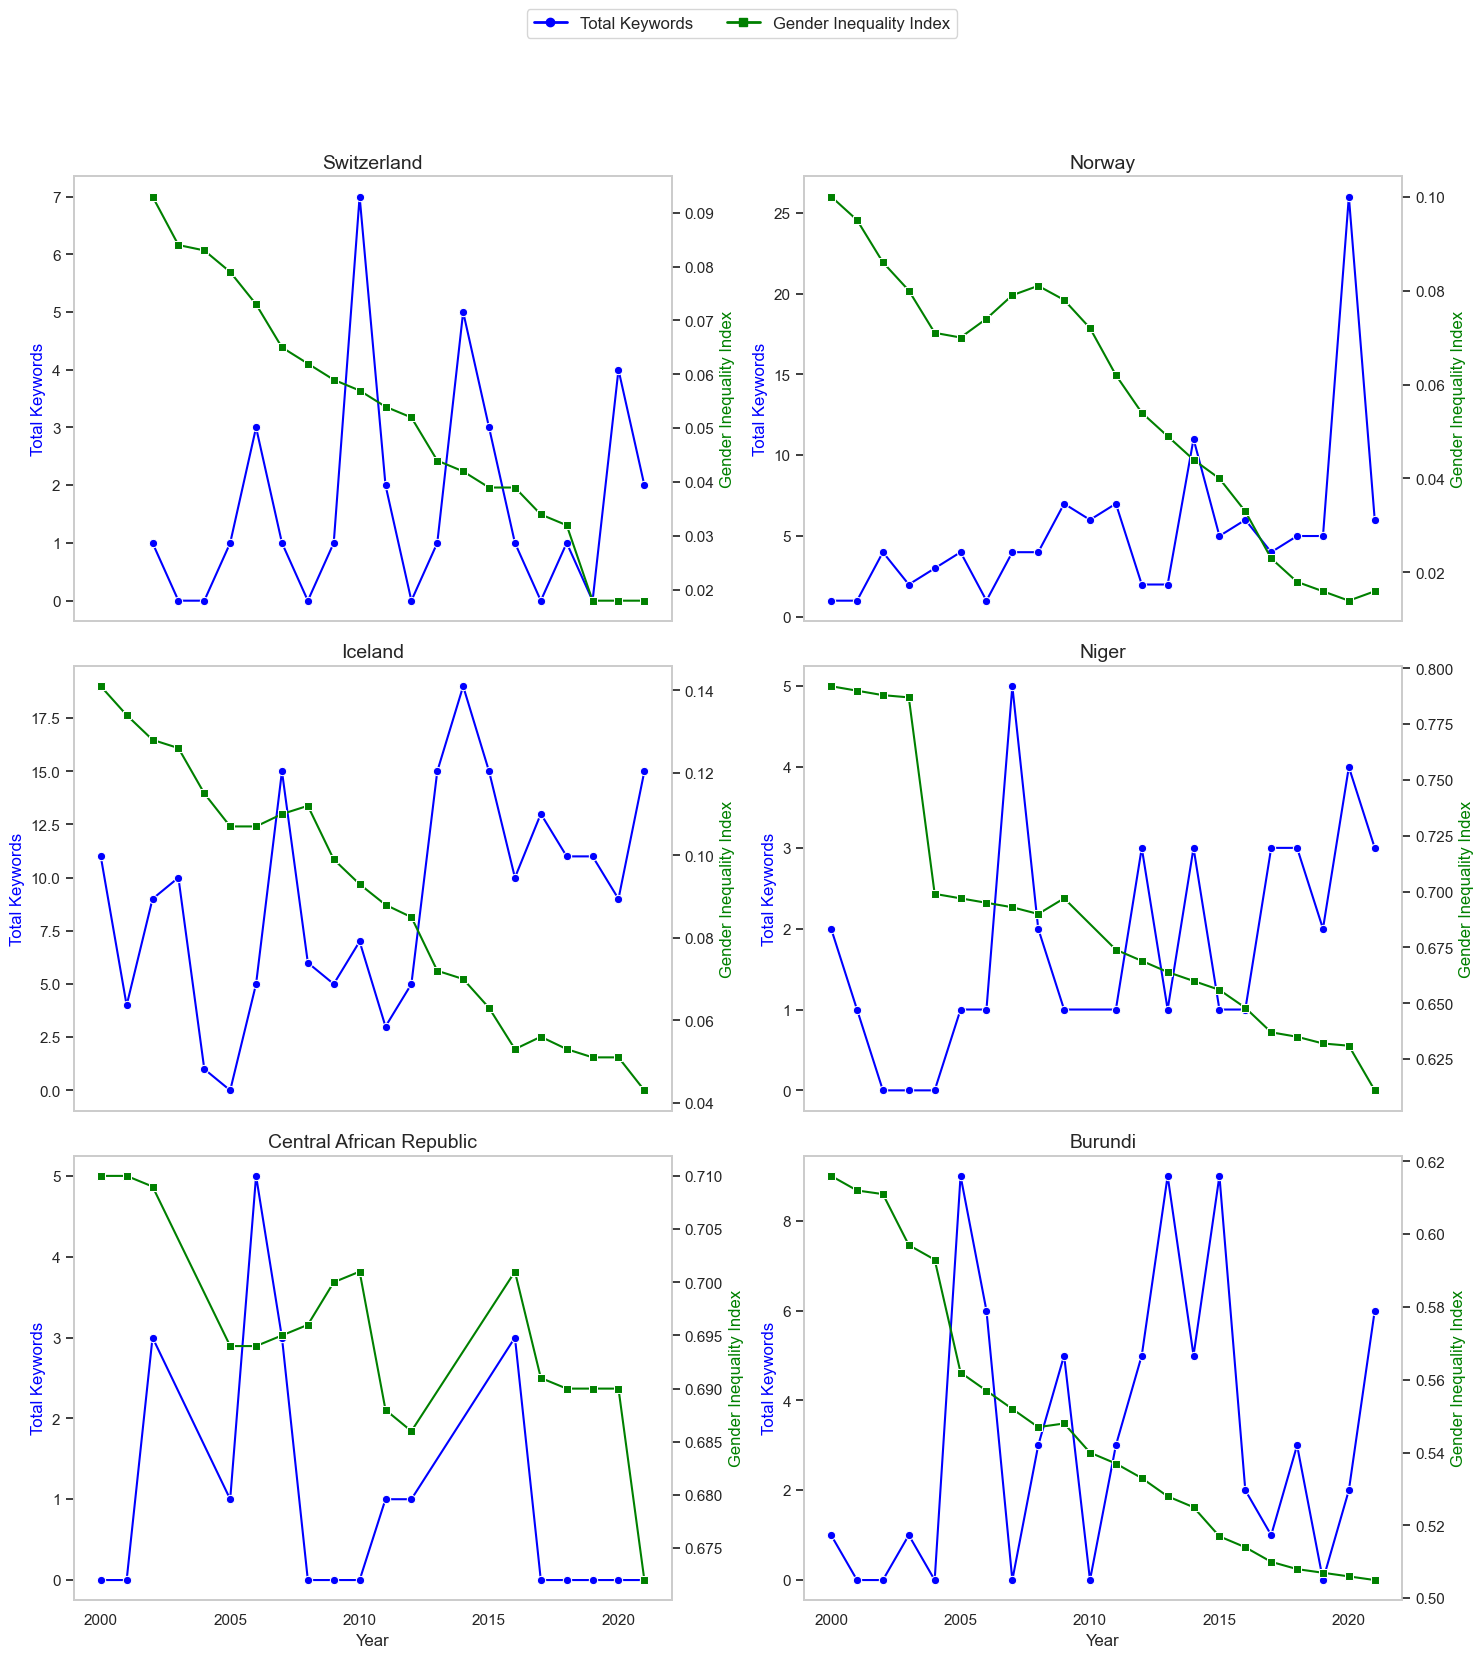

In [40]:
# Add a 'HDI_Category' column to each dataframe to differentiate them when combined
df_analysis_high_hdi['HDI_Category'] = 'High HDI'
df_analysis_low_hdi['HDI_Category'] = 'Low HDI'

# Concatenate the dataframes for visual comparison
df_analysis_combined = pd.concat([df_analysis_high_hdi, df_analysis_low_hdi], axis=0)

# Get the years for the x-axis and country codes for loop control
years = df_analysis_combined.index.get_level_values(1)
iso_codes = df_analysis_combined.index.get_level_values(0).unique()

# Set style and figure size
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 18), sharex=True, sharey=False)  # Changed to 3 rows, 2 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each country's data on separate subplots
for i, (iso_code, ax) in enumerate(zip(iso_codes, axes)):
    df_country = df_analysis_combined.loc[iso_code]  # Retrieve the filtered dataframe based on country name
    
    # Plot Total Keywords on the left y-axis with the same color but different marker for each country
    sns.lineplot(x=df_country.index.get_level_values(0), y=df_country['Total Keywords'], ax=ax,
                 color='blue', marker='o')
    
    # Create a secondary y-axis for Gender Inequality Index on the same plot
    ax2 = ax.twinx()
    sns.lineplot(x=df_country.index.get_level_values(0), y=df_country['Gender Inequality Index'], ax=ax2,
                 color='green', marker='s')
    
    # Set labels and title for each subplot
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Total Keywords', fontsize=12, color='blue')
    ax2.set_ylabel('Gender Inequality Index', fontsize=12, color='green')
    ax.set_title(df_country.loc[2002]['Country'], fontsize=14)
    
    # Customize axis colors for clarity
    ax.yaxis.label.set_color('blue')
    ax2.yaxis.label.set_color('green')
    
    # Remove grid for cleaner look
    ax.grid(False)
    ax2.grid(False)

# Manually create legend elements
legend_elements = [Line2D([0], [0], color='blue', lw=2, marker='o', label='Total Keywords'),
                   Line2D([0], [0], color='green', lw=2, marker='s', label='Gender Inequality Index')]

# Create a combined legend below the entire figure
fig.legend(handles=legend_elements, loc='lower center', fontsize=12, ncol=2, bbox_to_anchor=(0.5, 1))

# Adjust the layout to fit everything and display side-by-side
fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust rect to provide space for the global legend
plt.show()


##### Box plot of GIII for High/Low HDI countries

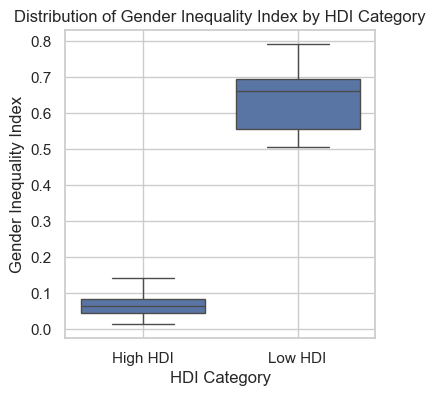

In [41]:
# Add a 'HDI_Category' column to each dataframe to differentiate them when combined
df_analysis_high_hdi['HDI_Category'] = 'High HDI'
df_analysis_low_hdi['HDI_Category'] = 'Low HDI'

# Concatenate the dataframes for visual comparison
df_analysis_combined = pd.concat([df_analysis_high_hdi, df_analysis_low_hdi], axis=0)

# Boxplot Comparison 
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_analysis_combined, x='HDI_Category', y='Gender Inequality Index')
plt.title('Distribution of Gender Inequality Index by HDI Category')
plt.xlabel('HDI Category')
plt.ylabel('Gender Inequality Index')
plt.grid(True)
plt.show()

##### Scatter plot of GII for High/Low HDI countries with trend line

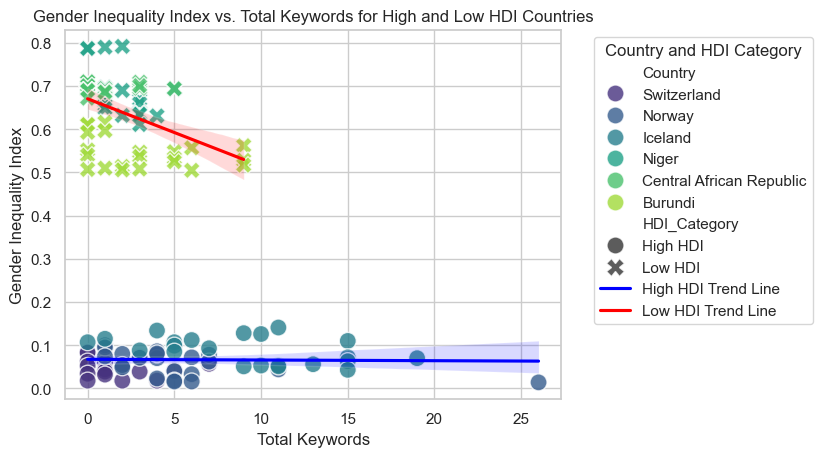

In [42]:
# Scatter plot for all countries with differentiation by 'Country' and 'HDI_Category'
sns.scatterplot(
    data=df_analysis_combined,
    x='Total Keywords', y='Gender Inequality Index',
    hue='Country',  
    style='HDI_Category', 
    palette='viridis', 
    s=150,  
    alpha=0.8  
)

# Fit regression lines for high HDI countries
sns.regplot(
    data=df_analysis_high_hdi,
    x='Total Keywords', y='Gender Inequality Index',
    scatter=False, color='blue', label='High HDI Trend Line'
)

# Fit regression lines for low HDI countries
sns.regplot(
    data=df_analysis_low_hdi,
    x='Total Keywords', y='Gender Inequality Index',
    scatter=False, color='red', label='Low HDI Trend Line'
)

# Add labels and title
plt.title('Gender Inequality Index vs. Total Keywords for High and Low HDI Countries')
plt.xlabel('Total Keywords')
plt.ylabel('Gender Inequality Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country and HDI Category')
plt.grid(True)
plt.show()


### Progress made in gender equality indicators
#### Unemployment rate (men and women), labor force participation rate, and parliamentary seats held by women

## Predictive:
To develop a predictive model that forecasts changes in gender equality indicators based on the sentiment expressed towards gender equality in political speeches and historical gender inequality index data.
Predict for 2024 data

In [43]:
df_merged = pd.merge(df_speech, df_gii, on=['Country Code', 'Year'])
df_merged = pd.merge(df_merged, df_labor_force, on=['Country Code', 'Year'])
df_merged = pd.merge(df_merged, df_parliament_seats, on=['Country Code', 'Year'])
df_merged = pd.merge(df_merged, unemploymentTotal, on=['Country Code', 'Year'])
df_merged.set_index(['Country Code', 'Year'], inplace=True)
df_merged.head()

,,Session,Speech,gender,women,girl,queer,female,feminis*,non-binary,non binary,...,trafficking,forced marriage,Country,Gender Inequality Index,Country Name_x,Labor force (%),Proportion Of Seats Held By Women In National Parliaments (%),Country Name_y,Unemployment females,Unemployment males
Country Code,Year,,,,,,,,,,,,,,,,,,,,,
AGO,2000,55,"allow me to begin by congratulating you, sir, ...",0,0,0,0,0,0,0,0,...,0,0,Angola,0.671,Angola,50.511,15.455,Angola,18.466,14.497
ALB,2000,55,"allow me to congratulate you, sir, on your ele...",0,0,0,0,0,0,0,0,...,0,0,Albania,0.319,Albania,41.907,5.161,Albania,18.538,19.374
ARE,2000,55,"i have the honour to convey to you, on behalf ...",0,0,0,0,0,0,0,0,...,0,0,United Arab Emirates,0.605,United Arab Emirates,12.206,0.000,United Arab Emirates,2.716,2.185
ARG,2000,55,"in this, my first statement, allow me to congr...",1,0,0,0,0,0,0,0,...,2,0,Argentina,0.413,Argentina,41.558,26.459,Argentina,16.360,14.033
ARM,2000,55,allow me to join my colleagues in congratulati...,0,0,0,0,0,0,0,0,...,0,0,Armenia,0.453,Armenia,48.713,3.053,Armenia,14.404,7.956


In [44]:
df_merged = df_merged.drop(columns=keywords)
df_merged[:][2000:].sort_index()
df_merged.sort_index()

Session                                             Speech  \
Country Code Year                                                               
AFG          2005       60  i have the honour to inform the members of the...   
             2006       61  every year our gathering  under this roof does...   
             2007       62  over the 62 years of its  existence, the gener...   
             2008       63  since the last time we  gathered here in this ...   
             2009       64  first, i would like to  congratulate his excel...   
...                    ...                                                ...   
ZWE          2017       72  i wish to congratulate mr. miroslav lajčák on ...   
             2018       73  it is my honour and pleasure to deliver my mai...   
             2019       74  allow me to congratulate mr. tijjani muhammad-...   
             2020       75  your excellency, ambassador volkan bozkir, pre...   
             2021       76  your excellency abdulla shahid, president of t...   

                       Country  Gender Inequality Index Country Name_x  \
Country Code Year                                                        
AFG          2005  Afghanistan                    0.748    Afghanistan   
             2006  Afghanistan                    0.749    Afghanistan   
             2007  Afghanistan                    0.752    Afghanistan   
             2008  Afghanistan                    0.755    Afghanistan   
             2009  Afghanistan                    0.755    Afghanistan   
...                        ...                      ...            ...   
ZWE          2017     Zimbabwe                    0.532       Zimbabwe   
             2018     Zimbabwe                    0.535       Zimbabwe   
             2019     Zimbabwe                    0.533       Zimbabwe   
             2020     Zimbabwe                    0.533       Zimbabwe   
             2021     Zimbabwe                    0.532       Zimbabwe   

                   Labor force (%)  \
Country Code Year                    
AFG          2005           17.190   
             2006           16.985   
             2007           16.795   
             2008           16.639   
             2009           16.548   
...                            ...   
ZWE          2017           50.462   
             2018           50.515   
             2019           50.591   
             2020           50.363   
             2021           50.343   

                   Proportion Of Seats Held By Women In National Parliaments (%)  \
Country Code Year                                                                  
AFG          2005                                             27.309               
             2006                                             27.309               
             2007                                             27.686               
             2008                                             27.686               
             2009                                             27.309               
...                                                              ...               
ZWE          2017                                             32.576               
             2018                                             31.481               
             2019                                             31.852               
             2020                                             31.852               
             2021                                             31.852               

                  Country Name_y  Unemployment females  Unemployment males  
Country Code Year                                                           
AFG          2005    Afghanistan                10.396               7.398  
             2006    Afghanistan                10.409               7.408  
             2007    Afghanistan                10.405               7.403  
             2008    Afghanis

In [45]:
# Handle NA data for GII
missing_gii = df_merged[df_merged['Gender Inequality Index'].isna()]
missing_gii.sort_index()

Session                                             Speech  \
Country Code Year                                                               
BTN          2001       56  ﻿i congratulate the president on his assumptio...   
             2002       57  ﻿we have before us an array of issues that are...   
             2003       58  ﻿it gives my delegation immense satisfaction t...   
             2004       59  on behalf of the delegation of bhutan, allow m...   
             2005       60  allow me to begin by extending my delegation’s...   
...                    ...                                                ...   
WSM          2006       61  forty-four years ago,  samoa became independen...   
             2007       62  samoa would like to  congratulate the presiden...   
             2008       63  the united nations  embodies multilateralism. ...   
             2009       64  the value of the  united nations to humanity h...   
             2010       65  our world continues  to change in profound way...   

                  Country  Gender Inequality Index Country Name_x  \
Country Code Year                                                   
BTN          2001  Bhutan                      NaN         Bhutan   
             2002  Bhutan                      NaN         Bhutan   
             2003  Bhutan                      NaN         Bhutan   
             2004  Bhutan                      NaN         Bhutan   
             2005  Bhutan                      NaN         Bhutan   
...                   ...                      ...            ...   
WSM          2006   Samoa                      NaN          Samoa   
             2007   Samoa                      NaN          Samoa   
             2008   Samoa                      NaN          Samoa   
             2009   Samoa                      NaN          Samoa   
             2010   Samoa                      NaN          Samoa   

                   Labor force (%)  \
Country Code Year                    
BTN          2001           40.761   
             2002           40.950   
             2003           41.176   
             2004           41.428   
             2005           41.800   
...                            ...   
WSM          2006           36.660   
             2007           36.718   
             2008           36.773   
             2009           36.835   
             2010           36.885   

                   Proportion Of Seats Held By Women In National Parliaments (%)  \
Country Code Year                                                                  
BTN          2001                                              9.333               
             2002                                              9.333               
             2003                                              9.333               
             2004                                              9.211               
             2005                                              9.333               
...                                                              ...               
WSM          2006                                              6.122               
             2007                                              8.163               
             2008                                              8.163               
             2009                                              8.163               
             2010                                              8.163               

                  Country Name_y  Unemployment females  Unemployment males  
Country Code Year                                                           
BTN          2001         Bhutan                 2.931               1.191  
             2002         Bhutan                 2.716               1.251  
             2003         Bhutan                 2.522               1.295  
             2004         Bhutan                 3.339               1.889  
             2005

In [46]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

keywords = ['gender', 'women', 'female', 'feminist', 'feminism', 
            'patriarchy', 'gender equality', 'violence against women', 'maternal']

def extract_relevant_sentences(text: str, keywords: list[str]) -> list[str]:
    sentences = sent_tokenize(text.lower())
    relevant_sentences = [sentence for sentence in sentences if any(keyword in sentence for keyword in keywords)]
    return relevant_sentences

def analyze_sentiment(sentences: list[str]) -> float:
    compound_scores = [sid.polarity_scores(sentence)['compound'] for sentence in sentences]
    if compound_scores:
        return min(compound_scores, key=abs)
    return 0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bylin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bylin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bylin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
df_sentiment = df_merged.copy()
df_sentiment['Relevant Text'] = df_sentiment['Speech'].apply(lambda x : extract_relevant_sentences(x, keywords))
df_sentiment['Sentiment Analysis'] = df_sentiment['Relevant Text'].apply(lambda x: analyze_sentiment(x))
df_sentiment['Previous Gender Inequality Index'] = df_sentiment.groupby('Country')['Gender Inequality Index'].shift(1)
df_sentiment.dropna(inplace=True)

df_sentiment.sort_index()

Session                                             Speech  \
Country Code Year                                                               
AFG          2006       61  every year our gathering  under this roof does...   
             2007       62  over the 62 years of its  existence, the gener...   
             2008       63  since the last time we  gathered here in this ...   
             2009       64  first, i would like to  congratulate his excel...   
             2010       65  i join previous  speakers in congratulating yo...   
...                    ...                                                ...   
ZWE          2017       72  i wish to congratulate mr. miroslav lajčák on ...   
             2018       73  it is my honour and pleasure to deliver my mai...   
             2019       74  allow me to congratulate mr. tijjani muhammad-...   
             2020       75  your excellency, ambassador volkan bozkir, pre...   
             2021       76  your excellency abdulla shahid, president of t...   

                       Country  Gender Inequality Index Country Name_x  \
Country Code Year                                                        
AFG          2006  Afghanistan                    0.749    Afghanistan   
             2007  Afghanistan                    0.752    Afghanistan   
             2008  Afghanistan                    0.755    Afghanistan   
             2009  Afghanistan                    0.755    Afghanistan   
             2010  Afghanistan                    0.753    Afghanistan   
...                        ...                      ...            ...   
ZWE          2017     Zimbabwe                    0.532       Zimbabwe   
             2018     Zimbabwe                    0.535       Zimbabwe   
             2019     Zimbabwe                    0.533       Zimbabwe   
             2020     Zimbabwe                    0.533       Zimbabwe   
             2021     Zimbabwe                    0.532       Zimbabwe   

                   Labor force (%)  \
Country Code Year                    
AFG          2006           16.985   
             2007           16.795   
             2008           16.639   
             2009           16.548   
             2010           16.556   
...                            ...   
ZWE          2017           50.462   
             2018           50.515   
             2019           50.591   
             2020           50.363   
             2021           50.343   

                   Proportion Of Seats Held By Women In National Parliaments (%)  \
Country Code Year                                                                  
AFG          2006                                             27.309               
             2007                                             27.686               
             2008                                             27.686               
             2009                                             27.309               
             2010                                             27.711               
...                                                              ...               
ZWE          2017                                             32.576               
             2018                                             31.481               
             2019                                             31.852               
             2020                                             31.852               
             2021                                             31.852               

                  Country Name_y  Unemployment females  Unemployment males  \
Country Code Year                                                            
AFG          2006    Afghanistan                10.409               7.408   
             2007    Afghanistan                10.405               7.403   
             2008    Afghanistan                10.426               7.420   
             2009    Afg

In [60]:
# Setting features
features = [
    'Labor force (%)',
    'Proportion Of Seats Held By Women In National Parliaments (%)',
    'Unemployment females',
    'Unemployment males',
    'Sentiment Analysis',
    'Previous Gender Inequality Index'
]

target = 'Gender Inequality Index'

# Setting train and test data
test_countries = ['Switzerland', 'Burundi', 'Central African Republic']
test_data = df_sentiment[df_sentiment['Country'].isin(test_countries)]
train_data = df_sentiment[~df_sentiment['Country'].isin(test_countries)]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

scaler = StandardScaler()
X_train_scaled_lr = scaler.fit_transform(X_train)
X_test_scaled_lr = scaler.transform(X_test)

lr_model = LinearRegression()

lr_model.fit(X_train_scaled_lr, y_train)

y_pred_lr = lr_model.predict(X_test_scaled_lr)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

test_data_reset = test_data.reset_index()

Linear Regression Performance:
MSE: 0.0000, R²: 0.9994


In [61]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

rf_model = RandomForestRegressor(random_state=123)

kfold = KFold(n_splits=5, shuffle=True, random_state=123)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_search.fit(X_train_rf, y_train)

best_rf_model = grid_search.best_estimator_

best_rf_model.fit(X_train_rf, y_train)
y_pred_rf = best_rf_model.predict(X_test_rf)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")


Random Forest Performance:
MSE: 0.0001, R²: 0.9985


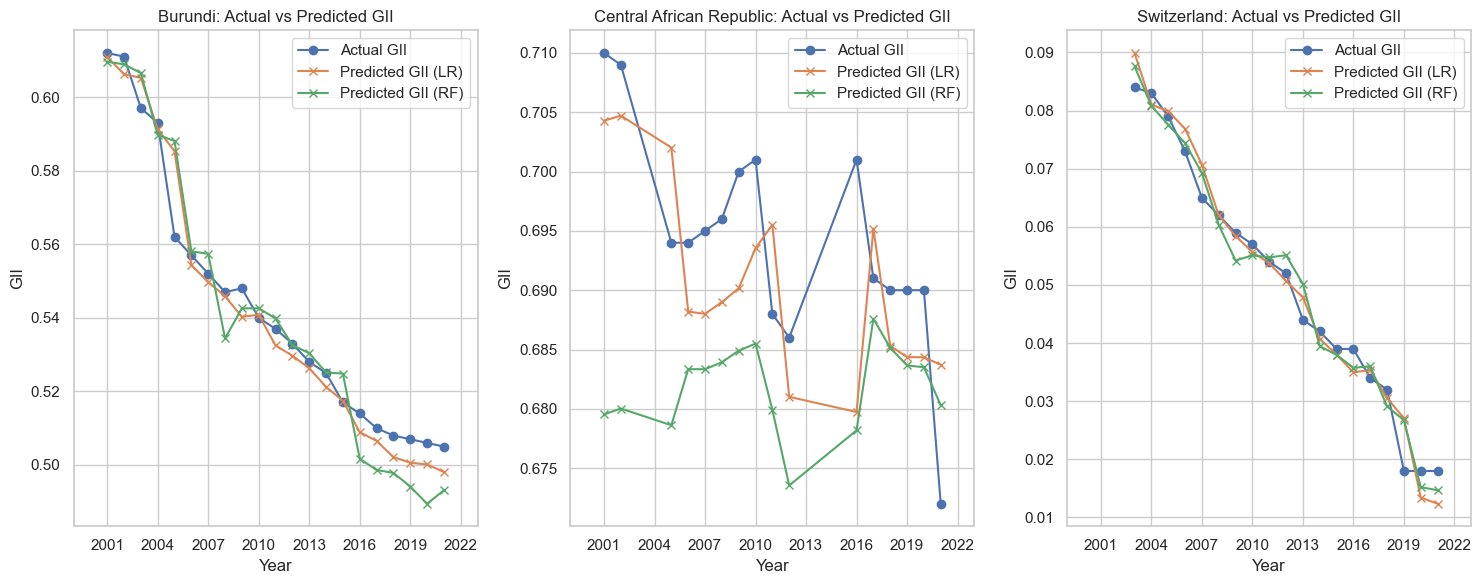

In [59]:
df_test = test_data.reset_index()

min_year = df_test['Year'].min() - 2
max_year = df_test['Year'].max() + 2

plt.figure(figsize=(15, 6))

countries = df_test['Country'].unique()

for i, country in enumerate(countries, 1):
    country_data = df_test[df_test['Country'] == country]
    
    plt.subplot(1, len(countries), i)
    
    # Plot actual GII
    plt.plot(country_data['Year'], country_data['Gender Inequality Index'], label='Actual GII', marker='o')
    
    # Plot predicted GII for both models
    plt.plot(country_data['Year'], y_pred_lr[df_test['Country'] == country], label='Predicted GII (LR)', marker='x')
    plt.plot(country_data['Year'], y_pred_rf[df_test['Country'] == country], label='Predicted GII (RF)', marker='x')
    
    plt.title(f"{country}: Actual vs Predicted GII")
    plt.xlabel("Year")
    plt.ylabel("GII")
    
    plt.xlim(min_year, max_year)
    
    # Ensure x-axis shows whole numbers for the years
    plt.gca().xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    plt.legend()

plt.tight_layout()
plt.show()